In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
#Upperbound para os pontos
N = 200
#Número de hospitais
H = 5
#Número de veículos
K = 30
#Número de Ocorrências
O = 10

In [19]:
#Cria uma matriz de coordenadas (x,y) aleatórias
coord = pd.DataFrame(100*np.random.rand(N,2),index=range(N),columns=["x","y"])
#Verifica se existem dois pontos iguais
if max(coord.value_counts()) > 1:
    count = 0
    for i in coord.value_counts():
        if i>1:
            #e então remove todos os que se aplicarem
            coord.drop(count)
        count+=1
    #por fim reindexando a matriz
    coord.index=pd.RangeIndex(0,len(coord))

In [20]:
#Cria as colunas com os arcos do vértice
coord[1] = coord[2] = coord[3] = coord[4] =-1

In [21]:
#Matriz de distância entre os pontos
_DistanceMatrix = pd.DataFrame(0.0,index=range(len(coord)),columns=range(len(coord)))

In [22]:
#Popula a matriz de distância com
#a distância euclidiana
for i in _DistanceMatrix.index:
    for j in _DistanceMatrix.index:
        dx = (coord.loc[i]["x"]-coord.loc[j]["x"])**2
        dy = (coord.loc[i]["y"]-coord.loc[j]["y"])**2
        _DistanceMatrix.loc[i][j] = (dx+dy)**(1/2)

In [23]:
#Lista de todos os nodos com arcos completos
_ConnectionMatrix = pd.DataFrame(False,index=range(len(coord)),columns=range(len(coord)))
completed = []
d={x:0 for x in _ConnectionMatrix.index}
for i in _ConnectionMatrix.index:
    #Contabiliza o número de conexões já feitas no nodo atual
    n_con = sum(_ConnectionMatrix.loc[i])
    #Se ainda faltar alguma conexão livre
    if n_con < 4:
        #Procura todos os nodos que ainda não foram completados
        incomplete = ~_ConnectionMatrix.index.isin(completed)
        
        #E todos os nodos que ainda não foram preenchidos em 'i'
        free = ~_ConnectionMatrix.loc[i].values
        
        #Ordena em ordem crescente todas as distâncias que satisfazem
        #as duas condições e pega os melhores arcos para completar 'i'
        sort = sorted(_DistanceMatrix.loc[i][incomplete&free])[1:1+(4-n_con)]
        
        #Separa quais os índices dos pontos de chegada determinados
        #na ordenação anterior
        bol = _DistanceMatrix.loc[i].isin(sort)
        
        string = str(i)+": "+str(_ConnectionMatrix.index[~free].values)+" -> "
        #Percorre esses indices
        for j in _DistanceMatrix.loc[i][bol].index:
        
            #Cria o arco 'i_j'
            _ConnectionMatrix.at[i,j] = True
            
            #Cria o arco 'j_i'
            _ConnectionMatrix.at[j,i] = True
            d[j]+=1
            d[i]+=1
            #Se 'j' completar adicionar 'j' na lista de nodos completos
            if sum(_ConnectionMatrix.loc[j]) == 4:
                completed.append(j)
        
        #Se 'i' completar adicionar 'i' na lista de nodos completos
        if sum(_ConnectionMatrix.loc[i]) == 4:
            completed.append(i)
        free = ~_ConnectionMatrix.loc[i].values
        string+= str(_ConnectionMatrix.index[~free].values)
        print(string)

0: [] -> [125 138 156 193]
1: [] -> [  3  23  85 142]
2: [] -> [ 59  67  88 165]
3: [1] -> [  1  85 187 198]
4: [] -> [ 44  97 143 145]
5: [] -> [11 27 78 83]
6: [] -> [ 29  92  96 196]
7: [] -> [59 67 77 87]
8: [] -> [131 142 167 187]
9: [] -> [ 89  90 107 117]
10: [] -> [ 46  56 133 195]
11: [5] -> [  5  30  78 198]
12: [] -> [ 33  94  98 166]
13: [] -> [ 23  71  76 155]
14: [] -> [ 34  40 122 135]
15: [] -> [ 42  44 109 186]
16: [] -> [ 92  96 150 181]
17: [] -> [ 22  88 105 199]
18: [] -> [125 138 156 193]
19: [] -> [144 158 164 170]
20: [] -> [ 41  54 162 163]
21: [] -> [ 38  57  84 127]
22: [17] -> [ 17  86 161 174]
23: [ 1 13] -> [  1  13  71 112]
24: [] -> [ 39  45 132 192]
25: [] -> [ 39  49 176 192]
26: [] -> [ 52 144 149 170]
27: [5] -> [ 5 30 78 83]
28: [] -> [ 45 103 116 171]
29: [6] -> [  6  92  96 196]
30: [11 27] -> [11 27 49 78]
31: [] -> [ 96 133 150 195]
32: [] -> [111 138 140 193]
33: [12] -> [ 12  94  98 189]
34: [14] -> [ 14  40 122 135]
35: [] -> [ 89 126 147 160

In [25]:
#Verifica se a instância é válida
for i in _ConnectionMatrix.index:
    if sum(_ConnectionMatrix.loc[i]) != 4:
        print(i)
        print(sum(_ConnectionMatrix.loc[i]))

In [26]:
#Preenche os arcos para cada ponto
for i in _ConnectionMatrix.index:
    #Pega todos os nodos em que existe um arco saindo de 'i'
    index = _ConnectionMatrix.index[_ConnectionMatrix.loc[i]]
    count=0
    
    for j in coord.columns[2:2+len(index)]: 
        coord.at[i,j] = index[count] #Adiciona 'ij' aos arcos de 'i'
        count+=1

In [27]:
sinal = 0 #Tempo entre as alterações de estado de um sinal
for i in coord.index:
    for j in coord.loc[i][2:]:
        #Somamos o tempo de cada arco
        if j != -1:
            sinal+=_DistanceMatrix.loc[i][j]
sinal = (sinal/(3*len(coord))) #O tempo de alteração vai ser a média

In [28]:
SignalState = pd.DataFrame(np.random.random((N,4))<0.5,index = coord.index, columns= coord.columns[2:],dtype=bool)

In [29]:
#Matriz de Estado Instântaneo, representa o estado dos sinais no momento 0
SignalInstantState = pd.DataFrame(False,index = coord.index, columns=["state"], dtype=bool)
SignalInstantState.loc[0][0]=True


visited = set()
#Nodo inicial
actual_node = 0

#Busca por profundidade, para encontrar ciclo principal
def dfs(visited,actual_node):
    visited.add(actual_node)
    not_visited = coord.loc[actual_node][2:][~coord.loc[actual_node][2:].isin(visited)]
    if len(not_visited)>0:
        for i in not_visited:
            if i != -1:
                #Pega a coluna que representa o nodo de índice 'i'
                column = coord.loc[actual_node][coord.loc[actual_node] == int(i)].index[0]
                #Realiza um XOR
                xor = SignalState.loc[actual_node][column] != SignalInstantState.loc[actual_node]["state"]
                #Prevê o estado do nodo 'i' no instante 0
                SignalInstantState.loc[int(i)]["state"] = xor
                
                index = coord.loc[actual_node][2:][coord.loc[actual_node][2:]==i].index[0]
                #Adiciona o nodo 'i'
                visited = dfs(visited,i)
        return visited
            
    else:
        return visited
#Lista dos nodos no ciclo principal
l = dfs(visited,0)

In [30]:
#Todos os índices de ciclos externos
aux = coord.index[~coord.index.isin(l)]
for i in aux:
    #Eliminação de ciclos externos
    coord.drop(i,inplace=True)
len(coord)

200

In [45]:
#Eliminação dos Índices de ciclos externos
SignalInstantState.drop(SignalInstantState.loc[~SignalInstantState.index.isin(coord.index)].index,inplace=True)
SignalState.drop(SignalState.loc[~SignalState.index.isin(coord.index)].index,inplace=True)

#Reindexação Geral
if len(coord) < N:
    for i in range(len(coord)):
        for j in range(len(coord)):
            for k in coord.loc[coord.index[j]][2:].index:
                if coord.loc[coord.index[j]][k] == coord.index[i]:
                    coord.loc[coord.index[j],k] = i
    coord.index = pd.RangeIndex(len(coord))
    SignalInstantState.index = pd.RangeIndex(len(coord))
    SignalState.index = pd.RangeIndex(len(coord))

In [46]:
#Pontos escolhidos como hospitais
hospitais = pd.DataFrame(coord.index[np.random.randint(0,len(coord),H)],columns=["P"])

In [47]:
#Instância dos Veículos
veiculos = pd.DataFrame(index=range(K),columns=["Inicial","LowerBound","UpperBound"])

for i in veiculos.index:
    #Ponto inicial do veículo, escolhido aleatoriamente
    inicial = hospitais.loc[np.random.randint(0,len(hospitais))]["P"]
    #Quantidade do mesmo tipo de veículo no mesmo hospital
    qntd = np.random.randint(1,5)
    #Para cada veículo do mesmo tipo
    for j in range(qntd):
        lb = np.random.randint(1,6)      #Temos a prioridade mínima pela qual ele atende
        ub = np.random.randint(5,11)     #e a prioridade máxima que ele consegue atender
        veiculos.loc[i+j] = [inicial,lb,ub] #Inserção do veículo na instância

In [48]:
#Ocorrências
ocurrences = pd.DataFrame(index=range(O),columns=["P"])
#Pontos que não estejam previamente ocupados por hospitais
aux = coord[~coord.index.isin(hospitais["P"].values)].index
for i in range(O):
    #Escolhe aleatoriamente dentro dos pontos livres
    ocurrences.loc[i]["P"] = aux[np.random.randint(0,len(aux))]
    

In [49]:
#Instância das vítimas
victims = pd.DataFrame(index=range(O),columns=["Ponto","Prioridade"])
for i in range(O):
    #Escolhe dentro dos pontos das ocorrências 
    victims.loc[i] = [ocurrences.loc[i]["P"],np.random.randint(1,11)]

In [50]:
#Salva as instâncias
veiculos.to_csv("k_"+str(K))
victims.to_csv("v_"+str(O))
coord.to_csv("n_"+str(len(coord)))
SignalInstantState.to_csv("si_"+str(len(SignalInstantState)))
SignalState.to_csv("s_"+str(len(SignalInstantState)))
_DistanceMatrix.to_csv("d_"+str(len(_DistanceMatrix)))

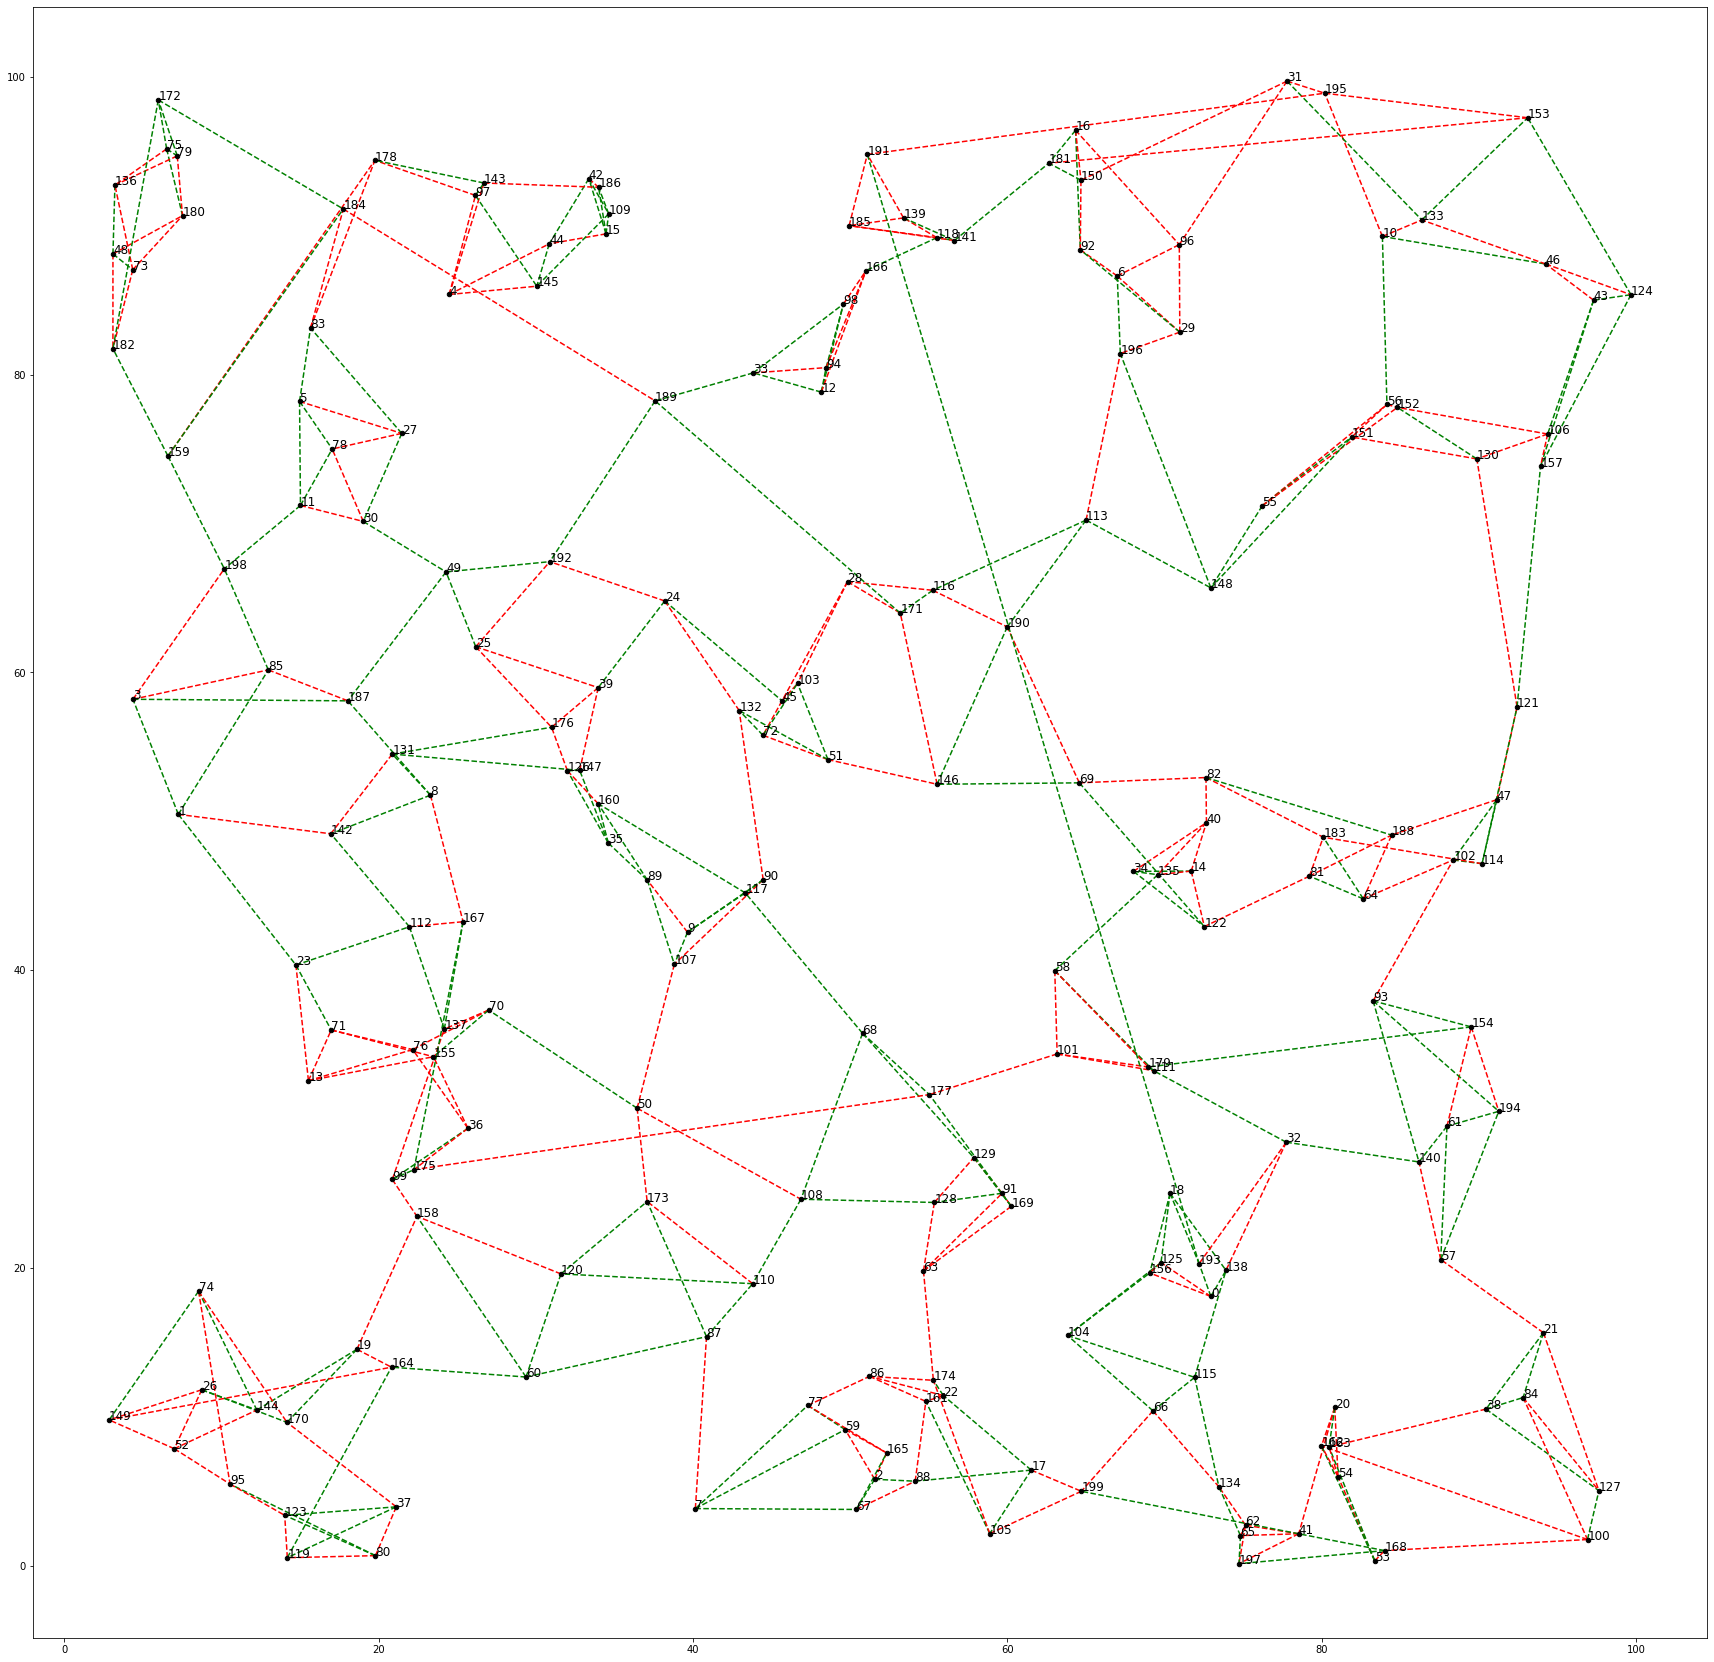

In [37]:
#Gera uma imagem do sistema criado
plt.figure(figsize=(30,30))
for i in coord.index:
    plt.scatter(coord.loc[i]["x"],coord.loc[i]["y"],s=20,color='black',zorder=1)
    plt.text(coord.loc[i]["x"],coord.loc[i]["y"],str(i),fontsize=12)

visitados = {x:[] for x in coord.index}
for i in coord.index:
    l = [int(x) for x in coord.loc[i][2:][coord.loc[i][2:] != -1]]
    xcoord = list(coord.loc[l]['x'].values)
    
    ycoord = list(coord.loc[l]['y'].values)
    
    for j in range(len(xcoord)):
        if l[j] not in visitados[i]:
            index = coord.loc[i][2:][coord.loc[i][2:] == l[j]].index[0]
            if SignalState.loc[i][index]:
                plt.plot([coord.loc[i]["x"],xcoord[j]],[coord.loc[i]["y"],ycoord[j]],'g--',zorder=0)
            else:
                plt.plot([coord.loc[i]["x"],xcoord[j]],[coord.loc[i]["y"],ycoord[j]],"r--",zorder=0)
        visitados[l[j]].append(i)

plt.savefig("n"+str(len(coord)))